# Gaussian Kernel method

## Introduction

This notebook implements the second method proposed by <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a>. It relies on the use of a Gaussian kernel. This kernel is used in order to define the kernel matrix.

A kernel is a semi-definite positive function. Its interpretation is that it measures the proximity between two data points. It can be shown that there is a function, called the feature function $\phi$ such as:

\begin{equation*}
    \forall \textbf{x}, \textbf{y}: k(\textbf{x}, \textbf{y}) \ = \ < \phi(\textbf{x}), \phi(\textbf{y})>
\end{equation*}

We can therefore see the kernel method as a conversion of the non-linear classification problem into a (high-dimensional) linear problem in the feature space, at the cost of computing the kernel of all pairs of points. The <a href="https://arxiv.org/abs/2101.11020">representer theorem </a> states that the model can be expressed in terms of only the input and the training data.

In particular, if we can compute the kernel matrix of the training dataset, i.e. $K = (k(x_i, x_j))_{i, j}$, the search of the model can be found by solving the linear system:
\begin{equation*}
    (K + \alpha I) \ \beta = y
\end{equation*}

where $\alpha$ is the regularization parameter and $y$ the label vector.

After solving for $\beta$, the model can be written as:
\begin{equation*}
    f(x) = \sum_{i = 1}^N \beta_i k(x, x_i),
\end{equation*}

where $x_i$ is the $i^{th}$ training 2d-vector.

The idea here is to train the $\lambda$ coefficients in the quantum observable defined by:

\begin{equation*}
\sum_{i, j} \lambda_{i, j} |<n_i, n_j| \mathcal{U}(\delta)|n, 0>|^2,
\end{equation*}

in order to convert a quantum circuit output into the desired Gaussian kernel:
\begin{equation*}
    k(\textbf{x}, \textbf{x'}) = e^{-\frac{1}{2 \sigma^2} || \textbf{x} - \textbf{x'}||^2},
\end{equation*}

The circuit proposed by <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a> is the following:

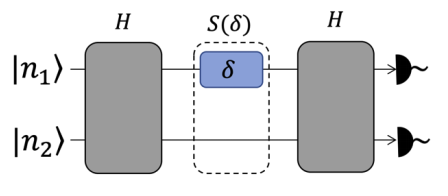

where $\delta = \Vert \textbf{x} - \textbf{x'} \Vert^2$ and the $H$ components are $50-50$-beam spliters.

The input state is the state $|n, 0>$, where $n$ is the number of photons, here $n = 10$.

## Learning of the quantum kernel

<a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a> does not provide an explicit method in order to train the quantum observable. It only states that it relies on the minimization of a quadratic loss function. We decided to follow this way.

Nevertheless, such a minimization was problematic. Indeed, the observable components must be in the order of magnitude of the million because of the high dimension of the Fock subspace (leading to small probabilities). Thus, the $\lambda$-vector lives in a high-dimensional large range. Accordingly, the variation happens on a so slow pace that we *compute* a zero-valued gradient. In order to be able to minimize, we needed to modify the scale of the input.

It turned out that reducing the magnitude of the $\lambda$-vector to $10^{-3}$ ($a = 4.5 \times 10^{-3})$ makes the minimization possible. We therefore multiply the circuit input by $10^{9}$ in order to get the right observable components magnitude.

In [1]:
import numpy as np
import perceval as pcvl
import perceval.lib.phys as phys
from math import comb
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping

### Definition of the constants, the circuit and the simulator

In [2]:
training_set = []  # a list of positive numbers for training the kernel
# initialize the circuit
m = 2 # number of modes
n = 10 # number of photons
input_state = pcvl.BasicState([n, 0]) # |n, 0>
delta = pcvl.P("delta") # phase shifter parameter delta = || x - y ||^2
a = 4.5e-3 # range of the lambda parameter
sigma = 1 # scale parameter
fock_dim = comb(n + m - 1, n) # dimension of the Fock subspace Phi_m,n

In [3]:
simulator_backend = pcvl.BackendFactory().get_backend("SLOS") # definition of the backend
s1 = simulator_backend(pcvl.Matrix.random_unitary(m)) # some matrix that will be changed later
s1.compile(input_state)
c = phys.BS() // (0, phys.PS(delta)) // phys.BS() # cicruit definition
pcvl.pdisplay(c) # graphical representation

### Definition of the approximate quantum kernel

In [4]:
def quantum_value1(d, lambda_random):
    """
    Wrapper that define the quantum circuit computation. Here the input is the value delta = || x - y ||^2
    """
    delta.set_value(d)
    U = c.compute_unitary(use_symbolic=False)
    s1.U = U
    return np.sum(np.multiply(s1.all_prob(input_state), 1e9 * lambda_random))

def quantum_value2(x1, x2, lambda_random):
    """
    Wrapper that define the quantum circuit computation. Here the input is the pair of points x1 and x2.
    The code computes || x1 - x2 ||^2 and then applies the quantum circuit
    """
    z = x1 - x2
    delta.set_value(z @ z)
    U = c.compute_unitary(use_symbolic=False)
    s1.U = U
    return np.sum(np.multiply(s1.all_prob(input_state), 1e9 * lambda_random))

#### Computation of the loss function

Here, we used the following quadratic loss function:

\begin{equation*}
    \mathcal{L}(\overrightarrow{\delta}, \lambda) = \frac{1}{2 N} \sum_{i = 1}^N \left(f(\delta_i, \lambda) - e^{- \frac{\delta_i}{2 \sigma^2}} \right)^2
\end{equation*}

where $\overrightarrow{\delta}$ is the training vector.

In [5]:
def computation(lambda_random):
    """
    Computes the quadratic loss function over the training set
    """
    global training_set
    loss = 0
    for i in range(len(training_set)):
        fvalue = quantum_value1(training_set[i], lambda_random)
        loss += np.linalg.norm(fvalue - np.exp(-training_set[i]/ (2 * sigma ** 2)))**2
    loss /= (2 * len(training_set))
    return loss

#### Training

In order to train our quantum kernel, we draw values from the law $U(0, 3)$. Sadly for us, we cannot train the quantum kernel for values outside of this range, since the function does not have a symmetry we could use. Some may suggest the following trick, which is "equivalent" to what we did in the RKS notebook:

\begin{equation*}
\exp(-x) = \left[\exp\left(-\frac{x}{\omega}\right)\right]^{\omega}
\end{equation*}

In spite of being a correct observation, being able to use this trick means that we are able to compute $a^{b}$ classicaly for all $a$ and $b$, hence the absence of need to a quantum kernel.

We **strongly** advise the user to keep the default values of the parameters (maybe change $N$).

In [6]:
def training(N=1000, niter_basin=1, niter_arg=1):
    """
    Generates the training set
    Minimizes the loss function using scipy.optimize.basinhopping
    
    Input:
    
        N: size of the training set
        niter_basin: number of calls to scipy.optimize.basinhopping
        niter_arg: number of basin hopping iteration in the function scipy.optimize.basinhopping.
    """
    global training_set
    training_set = np.random.uniform(low=0, high=3, size=N) # define the training vector
    loss = float("inf")
    
    for _ in range(niter_basin):
        lambda_random = np.random.uniform(size=fock_dim, low=0, high=a) # new random lambda parameter
        res = basinhopping(computation, lambda_random, disp=True, niter=niter_arg) # minimization via basinhopping
        if res.fun < loss:
            loss = res.fun
            print("#############\n")
            print(">>>> loss = " + str(loss) + "\n")
            print(">>>> lambda_random = " + str(res.x) + "\n")
            temp = deepcopy(res.x) # temp memorizes the best result so far
    print(temp)

In [7]:
training(100)

basinhopping step 0: f 6.96131e-06
basinhopping step 1: f 6.96133e-06 trial_f 6.96133e-06 accepted 1  lowest_f 6.96131e-06
#############

>>>> loss = 6.9613138746987834e-06

>>>> lambda_random = [ 0.00351166  0.00133635  0.00523741 -0.00379973  0.00965247 -0.00592803
  0.00655174 -0.0008905   0.00175255  0.00106309  0.00080323]

[ 0.00351166  0.00133635  0.00523741 -0.00379973  0.00965247 -0.00592803
  0.00655174 -0.0008905   0.00175255  0.00106309  0.00080323]


## Use of a pre-computed $\lambda$

### Importation of modules

In [7]:
import numpy as np
import perceval as pcvl
import perceval.lib.phys as phys
from math import comb
import sklearn.datasets as skdt
import time
from scipy.optimize import basinhopping
from copy import deepcopy
import matplotlib.pyplot as plt
import pybobyqa
from tqdm import tqdm

### Defintion of constants

A particular attention should be given to the regularization coefficient $\alpha$. Indeed, the Gaussian kernel classification is heavily dependent on its value. This reularization coefficient limits the expressive power of the classifier (relative to the Gaussian kernel). It should thus be fine-tuned accordingly to the complexity of the considerated dataset.

We advise the user to choose the following values:

1. linear datasets: $\alpha = 2$
2. Circular datasets: $\alpha = 1.5$
3. Moon datasets: $\alpha = 0.3$

The wrapper at the end of the notebook allows the user to change the regularization parameter value. No need to do it here.

In [8]:
h = .1    # step size in the mesh
alpha = 1  # regularization term

#### Value fo $\lambda$

The value of $\lambda$ was found through the minimization of the aformentioned loss function.

The loss is: $5.662418873300319\times 10^{-6}$.

In [9]:
lambda_random =np.array([ 0.00351458,  0.00133759,  0.00508492, -0.00329576,  0.00877446, -0.00496694,
  0.0058937,  -0.00063719,  0.00173574,  0.00103247,  0.00081615]) 

##### Comparaison between the quantum kernel and the real kernel
Since we can compute the real and quantum kernels, we can compare the accuracy of the approximation.

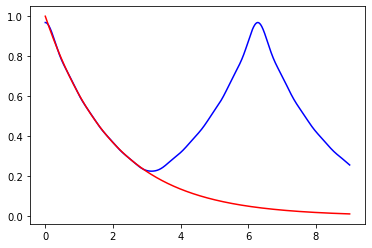

In [10]:
X = np.linspace(0, 9, num = 1000)
plt.plot(X, [quantum_value1(x, lambda_random) for x in X], 'b')
plt.plot(X, np.exp(-X/ (2 * sigma ** 2)), 'r')
plt.show()

### Data generation

The generated data is normalized as usual. Not only does it make the graphical representation easier, it guarentees that our values will remain more or less within the range (0, 3).

In [11]:
def normalizeX(z):
    """
    Sets the values between -1 and 1 linearly
    """
    zmax = np.max(z)
    zmin = np.min(z)
    return 2 * (z - zmin) / (zmax - zmin) - 1

def normalizey(z):
    """
    Values between -1 and 1 by replacing 0 values by -1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

def generate_data(type, N, noise_param):
    """
    Generates random datasets of different types
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: moon dataset
    
    >> Default noise values:
        - linear dataset: 1.5
        - circular dataset: 0.03
        - moon dataset: 0.1
    """
    if type == 0 and noise_param is None: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = 1.5)
    elif type == 0: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = noise_param)
    elif type == 1 and noise_param is None: # circlar
        X, y = skdt.make_circles(n_samples=N, noise=0.03)
    elif type == 1: # circlar
        X, y = skdt.make_circles(n_samples=N, noise= noise_param)
    elif type == 2 and noise_param is None: # moon
        X, y = skdt.make_moons(n_samples=N, noise=0.1)
    elif type == 2: # moon
        X, y = skdt.make_moons(n_samples=N, noise=noise_param)
    else:
        raise(ValueError("Invalid value of type. Enter help(generate_data) for more information"))
    # data normalization
    X = normalizeX(X)
    y = normalizey(y)
    return X, y

### Computation of the kernel matrix

In [12]:
def quantum_K_matrix(X):
    """
    Computation of the quantum Gaussian kernel
    """
    N = len(X)
    K = np.zeros((N, N))
    print(">>> Computing quantum kernel matrix")
    for i in tqdm(range(N)):
        for j in range(i, N):
            K[i, j] = quantum_value2(X[i], X[j], lambda_random)
    for i in range(N):
        for j in range(i): # Gaussian kernel matrix is symmetric
            K[i, j] = K[j, i]
    return K

### Resolution of the linear sytem

Even though <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a> claims that $\beta$ is computed through the formula:

\begin{equation*}
    \beta = (K + \alpha I)^{-1} y,
\end{equation*}

it is well-known that a linear system resolution is faster than a matrix inversion and a matricial product. We therefore encoded this formula through the resolution of the linear system:

\begin{equation*}
    (K + \alpha I) \ \beta = y
\end{equation*}

In [13]:
def solve(K, X, y):
    """
    Linear system resolution
    Input:
        K: kernel matrix
        X: training input points
        y: training labels
    """
    N = len(X)
    return np.linalg.solve(K + alpha * np.eye(N), y)

### Computation of the score

The score uses the usual formula. However, it is computed by using a yet unused set (what one may call a test set).

In [14]:
def quantum_scoring(X, y, X_train, beta):
    """
    Computes the score over the given set X and labels y using the given beta vector.
    """
    cpt = 0
    print(">>> Scoring")
    for i in tqdm(range(len(X))):
        fvalue = 0
        for j in range(len(X_train)): # computation of the classifier
            fvalue += beta[j] * quantum_value2(X[i], X_train[j], lambda_random)
        if np.sign(fvalue) == y[i]: cpt += 1
    return cpt / len(X)

### Graphical representation

The plot shows another unused set with the classification of the square $[-1.1, 1.1] \times [-1.1, 1.1]$.

In [15]:
def plot_quantum_fitting(X, y, beta, X_train, ret):
    """
    Defines the graphical representation which contains some points and their corresponding labels,
    the background is the classification of the square [-1.1, 1.1] x [-1.1, 1.1] and the score (given
    in the input) written in the title.
    """
    plt.figure(figsize=(8,8)) # Generate figure

    # create a mesh for the background
    N = len(X_train)
    xx = np.arange(-1.1, 1.1, h)
    yy = np.arange(-1.1, 1.1, h)
    zs = np.zeros((len(xx), len(yy)))
    print(">>> Plotting")
    for i in tqdm(range(len(xx))):
        for j in range(len(yy)):
            zs[i, j] = 0
            for k in range(N): # computation of the classifier
                zs[i, j] += beta[k] * quantum_value2(X_train[k], np.array([xx[i], yy[j]]), lambda_random)
            zs[i, j] = np.sign(zs[i, j])
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1,
        c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=18)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1,1.1)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret)) # write the score in the title
    plt.show()

### Wrapper

This wrapper calls the functions defined before. It starts by redefining $\alpha$, which turned out to be a *very important* parameter in the classification. Afterwards, it generates the data set (using the noise parameter if it is given) and divides it into three subsets (training, test and grapical representation). Then, it computes the kernel matrix and solves the linear system. Finally, it computes the score and shows the graphical representation.

In [16]:
def q_ker_fit(type, alpha_value, N = 100, noise_param=None):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps.
    1. alpha redefinition and data generation
    2. Definition of beta by resolving the linear system
    3. Score computation
    4. Graphical representation
    
    >> Default noise values:
        - linear dataset: 1.5
        - circular dataset: 0.03
        - moon dataset: 0.1
    """
    global alpha
    alpha = alpha_value # alpha redefinition
    
    X, y = generate_data(type, N, noise_param)
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))


    q_beta = solve(quantum_K_matrix(X[:prop1]), X[:prop1], y[:prop1]) # generate K-matrix and solve
    ret = quantum_scoring(X[prop1:prop2], y[prop1:prop2], X[:prop1], q_beta) # compute score
    print(">>>>>> quantum score: ", ret)

    plot_quantum_fitting(X[prop2:], y[prop2:], q_beta,  X[:prop1], ret) # show result


### Examples

One remark concerning the use of this method is that the quality of the result depends obviously on the size of the training set. Thus, in order to obtain scores, a high value of $N$ is required (even if that means a much longer running time).

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [06:34<00:00,  2.03it/s]


>>> Scoring


100%|██████████| 100/100 [01:33<00:00,  1.06it/s]


>>>>>> quantum score:  1.0
>>> Plotting


100%|██████████| 22/22 [06:12<00:00, 16.95s/it]


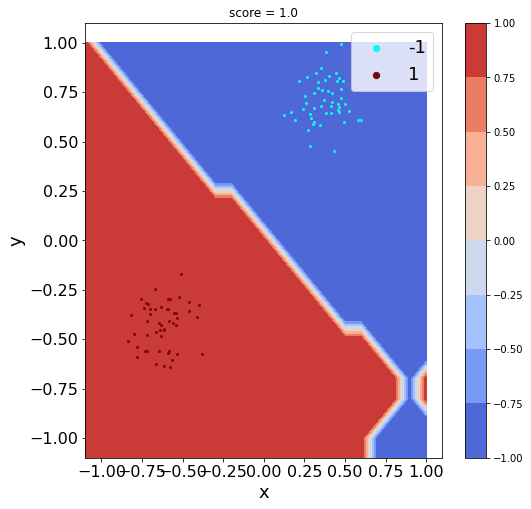

In [21]:
q_ker_fit(0, 2, 1000)

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [05:32<00:00,  2.40it/s]


>>> Scoring


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


>>>>>> quantum score:  0.87
>>> Plotting


100%|██████████| 22/22 [06:20<00:00, 17.30s/it]


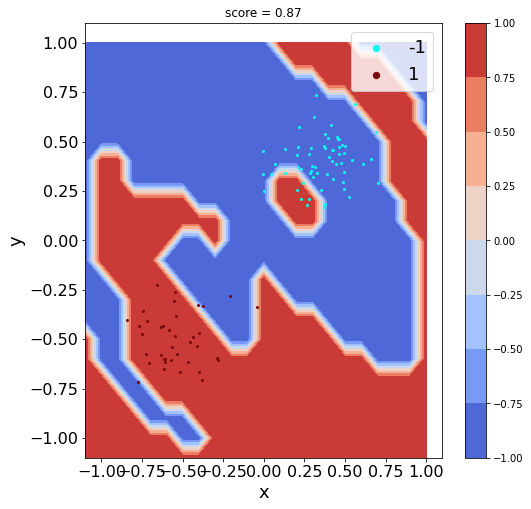

In [40]:
q_ker_fit(0, 2, 1000, 2.2)

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [05:28<00:00,  2.44it/s]


>>> Scoring


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


>>>>>> quantum score:  0.98
>>> Plotting


100%|██████████| 22/22 [06:20<00:00, 17.31s/it]


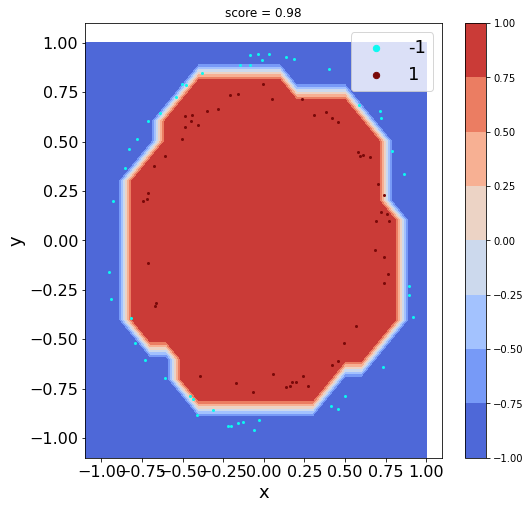

In [42]:
q_ker_fit(1, 1.5, 1000)

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [05:34<00:00,  2.39it/s]


>>> Scoring


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


>>>>>> quantum score:  0.72
>>> Plotting


100%|██████████| 22/22 [06:02<00:00, 16.46s/it]


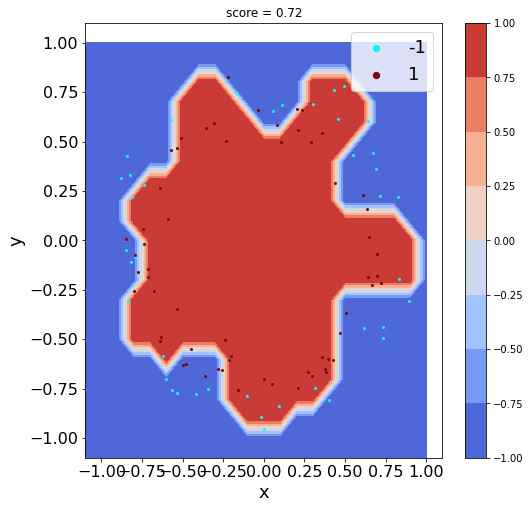

In [43]:
q_ker_fit(1, 1.5, 1000, 0.08)

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [05:12<00:00,  2.56it/s]


>>> Scoring


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


>>>>>> quantum score:  0.92
>>> Plotting


100%|██████████| 22/22 [05:59<00:00, 16.32s/it]


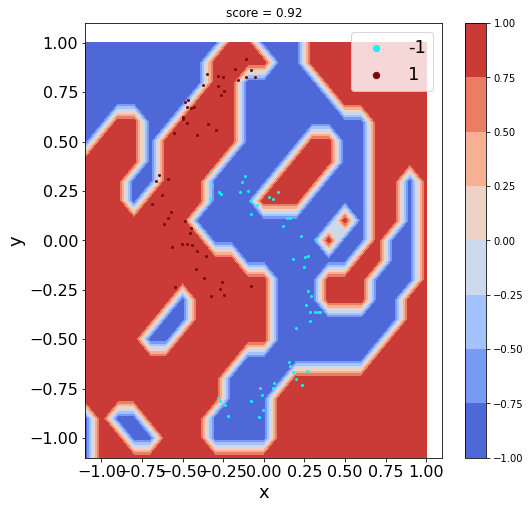

In [44]:
q_ker_fit(2, .3, 1000)

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [04:54<00:00,  2.71it/s]


>>> Scoring


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


>>>>>> quantum score:  0.97
>>> Plotting


100%|██████████| 22/22 [05:21<00:00, 14.61s/it]


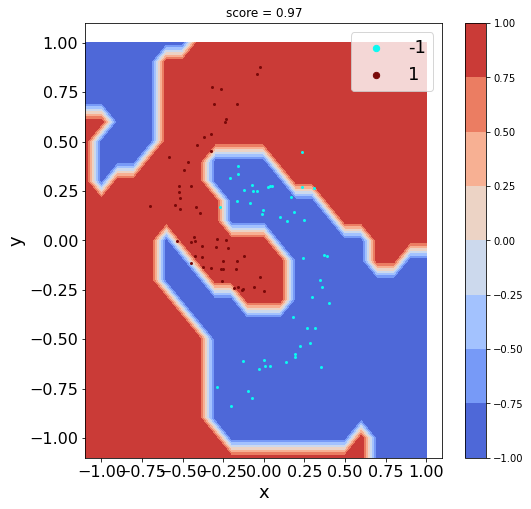

In [45]:
q_ker_fit(2, .3, 1000, 0.15)